# 17c: Combined Volcano Plots

**Goal**: Create publication-quality side-by-side volcano plots for E[V] and σ(V) enrichment.

**Method**: Combine 17a (winner/loser) and 17b (risk) volcano plots in a single figure.

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path

from forge.analysis.utils import viz

viz.setup_notebook_style()
plt.rcParams['font.size'] = 11
print("Ready")

Ready


In [2]:
# Load enrichment results
ev_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/17a_enrichment.csv"
risk_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/17b_risk_enrichment.csv"

ev_df = pd.read_csv(ev_path)
risk_df = pd.read_csv(risk_path)

# Add -log10(p)
ev_df['neg_log10_p'] = -np.log10(ev_df['p_value'].clip(lower=1e-10))
risk_df['neg_log10_p'] = -np.log10(risk_df['p_value'].clip(lower=1e-10))

print(f"E[V] enrichment: {len(ev_df)} dominoes")
print(f"Risk enrichment: {len(risk_df)} dominoes")

E[V] enrichment: 28 dominoes
Risk enrichment: 28 dominoes


## Publication-Quality Combined Volcano Plot

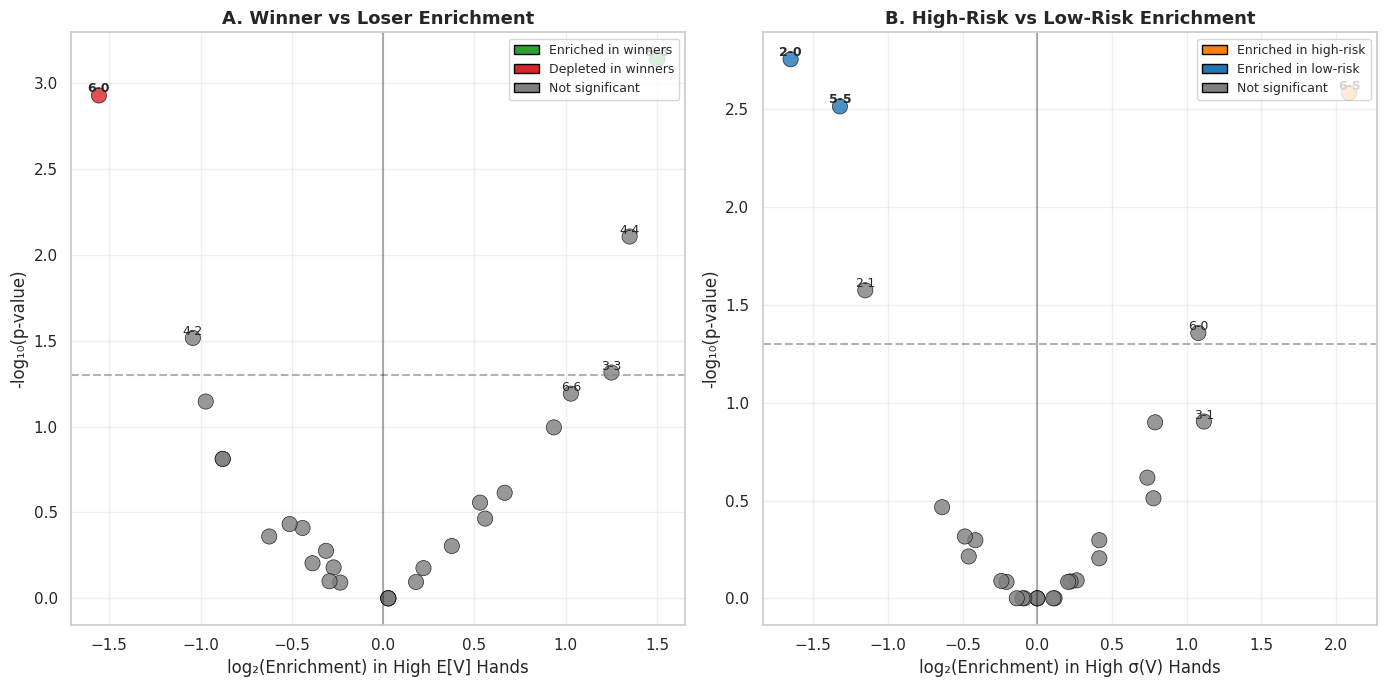

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Significance threshold
alpha = 0.05

# Common styling
def style_volcano(ax, df, title, xlabel, colors):
    """Style a volcano plot consistently."""
    ax.scatter(df['log2_enrichment'], df['neg_log10_p'], 
               c=colors, s=120, alpha=0.8, edgecolors='black', linewidth=0.5)
    
    # Add domino labels
    for _, row in df.iterrows():
        # Only label significant or extreme points
        if row['significant'] or abs(row['log2_enrichment']) > 1.0:
            ax.annotate(row['domino'], 
                       (row['log2_enrichment'], row['neg_log10_p']),
                       fontsize=9, ha='center', va='bottom',
                       fontweight='bold' if row['significant'] else 'normal')
    
    # Reference lines
    ax.axhline(-np.log10(alpha), color='gray', linestyle='--', alpha=0.6, 
               label=f'p = {alpha}')
    ax.axvline(0, color='black', linestyle='-', alpha=0.3)
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('-log₁₀(p-value)', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')

# Panel A: E[V] enrichment
colors_ev = []
for _, row in ev_df.iterrows():
    if row['significant'] and row['log2_enrichment'] > 0:
        colors_ev.append('#2ca02c')  # Green - enriched in winners
    elif row['significant'] and row['log2_enrichment'] < 0:
        colors_ev.append('#d62728')  # Red - depleted in winners
    else:
        colors_ev.append('#7f7f7f')  # Gray

style_volcano(axes[0], ev_df, 
              'A. Winner vs Loser Enrichment',
              'log₂(Enrichment) in High E[V] Hands',
              colors_ev)

# Panel B: Risk enrichment
colors_risk = []
for _, row in risk_df.iterrows():
    if row['significant'] and row['log2_enrichment'] > 0:
        colors_risk.append('#ff7f0e')  # Orange - enriched in high-risk
    elif row['significant'] and row['log2_enrichment'] < 0:
        colors_risk.append('#1f77b4')  # Blue - depleted in high-risk
    else:
        colors_risk.append('#7f7f7f')  # Gray

style_volcano(axes[1], risk_df,
              'B. High-Risk vs Low-Risk Enrichment',
              'log₂(Enrichment) in High σ(V) Hands',
              colors_risk)

# Add legends
legend_ev = [
    Patch(facecolor='#2ca02c', edgecolor='black', label='Enriched in winners'),
    Patch(facecolor='#d62728', edgecolor='black', label='Depleted in winners'),
    Patch(facecolor='#7f7f7f', edgecolor='black', label='Not significant'),
]
axes[0].legend(handles=legend_ev, loc='upper right', fontsize=9)

legend_risk = [
    Patch(facecolor='#ff7f0e', edgecolor='black', label='Enriched in high-risk'),
    Patch(facecolor='#1f77b4', edgecolor='black', label='Enriched in low-risk'),
    Patch(facecolor='#7f7f7f', edgecolor='black', label='Not significant'),
]
axes[1].legend(handles=legend_risk, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('../../results/figures/17c_volcano_combined.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('../../results/figures/17c_volcano_combined.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## Summary Statistics

In [4]:
print("E[V] Enrichment Analysis (Winner vs Loser)")
print("=" * 50)
sig_ev = ev_df[ev_df['significant']]
print(f"Significant (FDR < 0.05): {len(sig_ev)} dominoes")
for _, row in sig_ev.iterrows():
    direction = 'Winner-enriched' if row['log2_enrichment'] > 0 else 'Loser-enriched'
    print(f"  {row['domino']}: log₂ = {row['log2_enrichment']:.2f} ({direction})")

print(f"\nRisk Enrichment Analysis (High-Risk vs Low-Risk)")
print("=" * 50)
sig_risk = risk_df[risk_df['significant']]
print(f"Significant (FDR < 0.05): {len(sig_risk)} dominoes")
for _, row in sig_risk.iterrows():
    direction = 'High-risk-enriched' if row['log2_enrichment'] > 0 else 'Low-risk-enriched'
    print(f"  {row['domino']}: log₂ = {row['log2_enrichment']:.2f} ({direction})")

E[V] Enrichment Analysis (Winner vs Loser)
Significant (FDR < 0.05): 2 dominoes
  5-5: log₂ = 1.50 (Winner-enriched)
  6-0: log₂ = -1.56 (Loser-enriched)

Risk Enrichment Analysis (High-Risk vs Low-Risk)
Significant (FDR < 0.05): 3 dominoes
  6-5: log₂ = 2.09 (High-risk-enriched)
  5-5: log₂ = -1.32 (Low-risk-enriched)
  2-0: log₂ = -1.65 (Low-risk-enriched)


## Key Findings

### E[V] Enrichment (Panel A)
- **5-5**: +1.50 log₂ enrichment in winners (2.8× more common)
- **6-0**: -1.56 log₂ enrichment in winners (3× more common in losers)

### Risk Enrichment (Panel B)
- **6-5**: +2.09 log₂ enrichment in high-risk (4× more common)
- **5-5**: -1.32 log₂ enrichment in high-risk (good AND low-risk)
- **2-0**: -1.65 log₂ enrichment in high-risk (weak but predictable)

### Cross-Analysis Insight
**5-5 appears in both panels**: Enriched in winners AND depleted in high-risk hands.
This confirms the inverse E[V]-σ(V) relationship: good dominoes lead to both better AND more predictable outcomes.

### Output Files

- `results/figures/17c_volcano_combined.png` - 300 DPI
- `results/figures/17c_volcano_combined.pdf` - Vector format